In [1]:
import numpy as np

In [2]:
F_info=np.load("learned_ndv_estimator/model_training/training_data/rfs_F_infos.npy")

In [3]:
F_info.shape

(40000, 4)

In [4]:
f_s=np.load("learned_ndv_estimator/model_training/training_data/rfs_f_s.npy",allow_pickle=True)

In [5]:
import numpy as np
from numpy.polynomial import Chebyshev
from numpy.polynomial import Hermite
from scipy import optimize
from scipy.special import comb
from estndv import ndvEstimator

In [6]:
import pandas as pd
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from matplotlib import style
#plt.rcParams['font.sans-serif']=['simhei']
matplotlib.rcParams['text.usetex'] = True
from collections import Counter
import scipy

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter
from scipy.special import comb
from scipy import interpolate
import scipy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PolylpNet(nn.Module):
    def __init__(self,L=7,H=200,alpha=0.5):
        super(PolylpNet,self).__init__()
        self.L = L
        self.H = H
        self.alpha = alpha
        #self.weight = Parameter(torch.Tensor(L+2))
        self.weight = Parameter(torch.Tensor(self.H))
        self.weight.requires_grad = True
        self.fc1 = nn.Linear(self.L*10, self.L*10//2)
        self.fc2 = nn.Linear(self.L*10//2, self.L)
        self.fc3 = nn.Linear(self.L, self.L)
        self.fc1.requires_grad = True
        self.fc2.requires_grad = True
        self.fc3.requires_grad = True
        self.i = torch.Tensor( [ i+1 for i in range(self.H) ] ).float().to(device)
    def set_paras(self):
        #self.weight.data = torch.Tensor([1.0 for i in range(self.L+2)])
        self.weight.data = torch.Tensor([1.0 for i in range(self.H)])
    def forward(self,fi,M_tensor,N,n):
        bt_temp= F.leaky_relu(self.fc1( fi ) )
        bt=F.leaky_relu(self.fc2(bt_temp))
        temp = torch.einsum('ij,ijk->ik', bt,M_tensor)
        temp =  temp-(( self.i.reshape(self.H,1)/N.reshape(1,N.shape[0]))**self.alpha).t() #).view(1,self.H)
        temp=(temp*(self.weight/self.weight.sum())).sum(1)
        f0 = F.relu(self.fc3( bt ).sum(1) )
        return f0,temp

alpha=0.5
penet = PolylpNet().to(device)
penet.set_paras()
for param in penet.parameters():
    param.data = param.data.to(device)

optimizer = torch.optim.Adam(penet.parameters(),lr=0.001)

# data prepare

fea = torch.tensor([[0.0 for j in range(70)]  for i in range(f_s.shape[0])]).to(device)
lp_plus=[]
for i in range(f_s.shape[0]):
    f_s_n=sum(f_s[i][:,0]*f_s[i][:,1])
    lp_p=0.0
    for item in f_s[i]:
        if item[0]>70:
            lp_p+= item[1]*(item[0]/f_s_n)**alpha
        else:
            fea[i][item[0]-1]=item[1]
            lp_p+= item[1]*(item[0]/f_s_n)**alpha
    lp_plus.append(lp_p)
lp_plus = torch.Tensor(lp_plus).to(device)

d = torch.tensor([ sum(f[:,1]) for f in f_s]).to(device)
n = torch.tensor([ sum(f[:,0]*f[:,1]) for f in f_s] ).to(device)
lpd = torch.tensor( [sum( f[:,1]*(f[:,0]/sum(f[:,0]*f[:,1]))**alpha ) for f in f_s] ).to(device)
N = torch.tensor(F_info[:,0]).to(device)
LP = torch.tensor( F_info[:,3]).to(device)

M_tensor=[]
size = F_info.shape[0]
L=7
H=200
data_n=np.array([sum(te[:,1]) for te in f_s])
data_N=F_info[:,0]
for s in range(size):
    M=[]
    for t in range(1,L+1):
        M_temp=[]
        for j in range(1,H+1):
            M_temp.append( comb(data_n[s],t)*(j/(data_N[s]-j))**t)
        M.append(M_temp)
    M=np.array(M)
    M[M<0.001]=0
    M_tensor.append(M)    
M_tensor = torch.tensor(M_tensor).float().to(device)


# def lossfun_lp(y,y_pred,d,n,N,l0_loss):
#     l_log_unreduced = torch.square( torch.log( (y_pred+d)/(y+d)))
#     l_bound = torch.sqrt(( (1 / (n.true_divide(N) + 1e-10) - 1) / 2 * 0.2554128 + d) / (d + 1e-6))
#     l_log_bound = torch.square(torch.log(l_bound))
#     l = torch.mean(torch.abs(l_log_unreduced - l_log_bound) + l_log_bound + 0.5*torch.log(l0_loss.abs()+1))  
#     print(torch.mean(torch.abs(l_log_unreduced - l_log_bound)),torch.mean(torch.log(1+l0_loss.abs())))
#     return torch.log(l)
def lossfun_lp(y,y_pred,l0_loss):
    #print( torch.mean(torch.square(y_pred-y)) , torch.mean(l0_loss.abs()))
    l=torch.mean(  torch.log( (y_pred-y).abs()+1)+ torch.log( l0_loss.abs()+1) )
    return l

batch_size=100
train_loss=[]
for i in range(600):
    print("epoch",i)
    for epoch in range(100):
        predict,l0_loss=penet(
            fea[epoch*batch_size:((epoch+1)*batch_size)] , 
            M_tensor[epoch*batch_size:((epoch+1)*batch_size)],
            N[epoch*batch_size:((epoch+1)*batch_size)],
            n[epoch*batch_size:((epoch+1)*batch_size)])
        y=torch.relu(LP-lp_plus)
#         loss=lossfun_lp(y[epoch*batch_size:((epoch+1)*batch_size)],predict,
#                      lpd[epoch*batch_size:((epoch+1)*batch_size)],
#                      #torch.tensor(F_info[epoch*batch_size:((epoch+1)*batch_size),1]),
#                      n[epoch*batch_size:((epoch+1)*batch_size)],
#                      torch.tensor(F_info[epoch*batch_size:((epoch+1)*batch_size),0]).to(device),
#                      l0_loss)
        loss = lossfun_lp(y[epoch*batch_size:((epoch+1)*batch_size)],predict,l0_loss)
        loss.requires_grad_(True)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss.append(loss)

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40
epoch 41
epoch 42
epoch 43
epoch 44
epoch 45
epoch 46
epoch 47
epoch 48
epoch 49
epoch 50
epoch 51
epoch 52
epoch 53
epoch 54
epoch 55
epoch 56
epoch 57
epoch 58
epoch 59
epoch 60
epoch 61
epoch 62
epoch 63
epoch 64
epoch 65
epoch 66
epoch 67
epoch 68
epoch 69
epoch 70
epoch 71
epoch 72
epoch 73
epoch 74
epoch 75
epoch 76
epoch 77
epoch 78
epoch 79
epoch 80
epoch 81
epoch 82
epoch 83
epoch 84
epoch 85
epoch 86
epoch 87
epoch 88
epoch 89
epoch 90
epoch 91
epoch 92
epoch 93
epoch 94
epoch 95
epoch 96
epoch 97
epoch 98
epoch 99
epoch 100
epoch 101
epoch 102
epoch 103
epoch 104
epoch 105
epoch 106
epoch 107
epoch 108
epoch 109
epoch 110


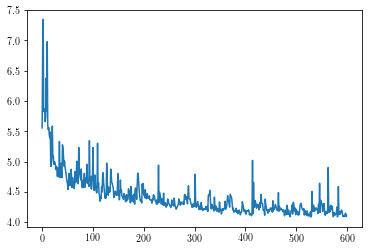

In [23]:
plt.plot(train_loss)

In [24]:
def Fi2fi(Fi,q):
    fs = []
    for item in Fi:
        f_i=np.random.binomial(item[0],q,size=item[1])
        fs.append(f_i)
    fs = np.concatenate(fs)
    fs = fs[fs>0]
    unique, counts = np.unique(fs,return_counts=True)
    f_sparse = np.array([unique,counts]).T
    return f_sparse
renEsti=ndvEstimator()
import os
Dir="kasandr"
q=0.001
kasResult=[]
order_D = []
En_list=[]
for filename in os.listdir(Dir):
    pathname=os.path.join(Dir,filename)
    Fi=np.loadtxt(pathname,delimiter=",",dtype=int)
    if len(Fi.shape)==1:
        Fi=np.array([Fi])
    r1=[]
    r2=[]
    r3=[]
    r4=[]
    r5=[]
    r6=[]
    r7=[]
    
    En_list.append( sum( Fi[:,1]*(Fi[:,0]/sum(Fi[:,1]*Fi[:,0]))**alpha ) )
    for r in range(10):
        fii=Fi2fi(Fi,q)
        fi_temp=fii
        max_i=max(max(fi_temp[:,0]),L)
        fi_dict={ item[0]:item[1] for item in fi_temp }
        fi=[]
        n=0
        for i in range(1,max_i+1):
            if i in fi_dict.keys():
                fi.append([i,fi_dict[i]])
                n+=i*fi_dict[i]
            else:
                fi.append([i,0])
        fi=np.array(fi)
        
        N=sum(Fi[:,0]*Fi[:,1])
        Elp=sum( Fi[:,1]*(Fi[:,0]/sum(Fi[:,1]*Fi[:,0]))**alpha )
        temp = sum( fii[:,1]*(fii[:,0]/sum(fii[:,1]*fii[:,0]))**alpha )
        r1.append( max(temp/Elp,Elp/temp ))
        
        L=7
        H=200
        data_n=n
        data_N=N
        M=[]
        for t in range(1,L+1):
            M_temp=[]
            for j in range(1,H+1):
                M_temp.append( comb(n,t)*(j/(N-j))**t)
            M.append(M_temp)
        M=np.array(M)
        M[M<0.001]=0
        feat=[0.0 for i in range(70)]
        for item in fii:
            if item[0]>70:
                continue
            else:
                feat[item[0]-1]=item[1]
        temp=penet(torch.tensor([feat]).float().to(device),
                  torch.tensor([M]).float().to(device),
                  torch.tensor([N]).float().to(device),
                  torch.tensor([n]).float().to(device),
                 )[0].cpu().detach().numpy()+sum( fi[:,1]*(fi[:,0]/sum(fi[:,1]*fi[:,0]))**alpha )
        r5.append( max(temp/Elp,Elp/temp ) )   
    kasResult.append([np.median(r1),
                  np.median(r5)])
kasResult=np.array(kasResult)
for i in range(kasResult.shape[1]):
    print(np.mean(kasResult[:,i]))

3.178831378490862
2.2187906333378384


In [25]:
def Fi2fi(Fi,q):
    fs = []
    for item in Fi:
        f_i=np.random.binomial(item[0],q,size=item[1])
        fs.append(f_i)
    fs = np.concatenate(fs)
    fs = fs[fs>0]
    unique, counts = np.unique(fs,return_counts=True)
    f_sparse = np.array([unique,counts]).T
    return f_sparse
renEsti=ndvEstimator()
import os
Dir="kasandr"
q=0.005
kasResult=[]
order_D = []
En_list=[]
for filename in os.listdir(Dir):
    pathname=os.path.join(Dir,filename)
    Fi=np.loadtxt(pathname,delimiter=",",dtype=int)
    if len(Fi.shape)==1:
        Fi=np.array([Fi])
    r1=[]
    r2=[]
    r3=[]
    r4=[]
    r5=[]
    r6=[]
    r7=[]
    
    En_list.append( sum( Fi[:,1]*(Fi[:,0]/sum(Fi[:,1]*Fi[:,0]))**alpha ) )
    for r in range(10):
        fii=Fi2fi(Fi,q)
        fi_temp=fii
        max_i=max(max(fi_temp[:,0]),L)
        fi_dict={ item[0]:item[1] for item in fi_temp }
        fi=[]
        n=0
        for i in range(1,max_i+1):
            if i in fi_dict.keys():
                fi.append([i,fi_dict[i]])
                n+=i*fi_dict[i]
            else:
                fi.append([i,0])
        fi=np.array(fi)
        
        N=sum(Fi[:,0]*Fi[:,1])
        Elp=sum( Fi[:,1]*(Fi[:,0]/sum(Fi[:,1]*Fi[:,0]))**alpha )
        temp = sum( fii[:,1]*(fii[:,0]/sum(fii[:,1]*fii[:,0]))**alpha )
        r1.append( max(temp/Elp,Elp/temp ))
        
        L=7
        H=200
        data_n=n
        data_N=N
        M=[]
        for t in range(1,L+1):
            M_temp=[]
            for j in range(1,H+1):
                M_temp.append( comb(n,t)*(j/(N-j))**t)
            M.append(M_temp)
        M=np.array(M)
        M[M<0.001]=0
        feat=[0.0 for i in range(70)]
        for item in fii:
            if item[0]>70:
                continue
            else:
                feat[item[0]-1]=item[1]
        temp=penet(torch.tensor([feat]).float().to(device),
                  torch.tensor([M]).float().to(device),
                  torch.tensor([N]).float().to(device),
                  torch.tensor([n]).float().to(device),
                 )[0].cpu().detach().numpy()+sum( fi[:,1]*(fi[:,0]/sum(fi[:,1]*fi[:,0]))**alpha )

        r5.append( max(temp/Elp,Elp/temp ) )
        
    kasResult.append([np.median(r1),
                  np.median(r5)])
        

kasResult=np.array(kasResult)
for i in range(kasResult.shape[1]):
    print(np.mean(kasResult[:,i]))

1.8852929377911456
1.368723017828805


In [26]:
def Fi2fi(Fi,q):
    fs = []
    for item in Fi:
        f_i=np.random.binomial(item[0],q,size=item[1])
        fs.append(f_i)
    fs = np.concatenate(fs)
    fs = fs[fs>0]
    unique, counts = np.unique(fs,return_counts=True)
    f_sparse = np.array([unique,counts]).T
    return f_sparse
renEsti=ndvEstimator()
import os
Dir="Airlines"
q=0.001
Result=[]
order_D = []
En_list=[]
for filename in os.listdir(Dir):
    pathname=os.path.join(Dir,filename)
    Fi=np.loadtxt(pathname,delimiter=",",dtype=int)
    if len(Fi.shape)==1:
        Fi=np.array([Fi])
    r1=[]
    r2=[]
    r3=[]
    r4=[]
    r5=[]
    r6=[]
    r7=[]
    
    En_list.append( sum( Fi[:,1]*(Fi[:,0]/sum(Fi[:,1]*Fi[:,0]))**alpha ) )
    for r in range(10):
        fii=Fi2fi(Fi,q)
        fi_temp=fii
        max_i=max(max(fi_temp[:,0]),L)
        fi_dict={ item[0]:item[1] for item in fi_temp }
        fi=[]
        n=0
        for i in range(1,max_i+1):
            if i in fi_dict.keys():
                fi.append([i,fi_dict[i]])
                n+=i*fi_dict[i]
            else:
                fi.append([i,0])
        fi=np.array(fi)
        
        N=sum(Fi[:,0]*Fi[:,1])
        Elp=sum( Fi[:,1]*(Fi[:,0]/sum(Fi[:,1]*Fi[:,0]))**alpha )

        temp = sum( fii[:,1]*(fii[:,0]/sum(fii[:,1]*fii[:,0]))**alpha )
        r1.append( max(temp/Elp,Elp/temp ))
        
        L=7
        H=200
        data_n=n
        data_N=N
        M=[]
        for t in range(1,L+1):
            M_temp=[]
            for j in range(1,H+1):
                M_temp.append( comb(n,t)*(j/(N-j))**t)
            M.append(M_temp)
        M=np.array(M)
        M[M<0.001]=0
        feat=[0.0 for i in range(70)]
        for item in fii:
            if item[0]>70:
                continue
            else:
                feat[item[0]-1]=item[1]
        temp=penet(torch.tensor([feat]).float().to(device),
                  torch.tensor([M]).float().to(device),
                  torch.tensor([N]).float().to(device),
                  torch.tensor([n]).float().to(device),
                 )[0].cpu().detach().numpy()+sum( fi[:,1]*(fi[:,0]/sum(fi[:,1]*fi[:,0]))**alpha )

        r5.append( max(temp/Elp,Elp/temp ) )
        
    Result.append([np.median(r1),
                  np.median(r5)])
        

Result=np.array(Result)
for i in range(Result.shape[1]):
    print(np.mean(Result[:,i]))

1.038822926439107
1.0196556568145752


In [27]:
def Fi2fi(Fi,q):
    fs = []
    for item in Fi:
        f_i=np.random.binomial(item[0],q,size=item[1])
        fs.append(f_i)
    fs = np.concatenate(fs)
    fs = fs[fs>0]
    unique, counts = np.unique(fs,return_counts=True)
    f_sparse = np.array([unique,counts]).T
    return f_sparse
renEsti=ndvEstimator()
import os
Dir="Airlines"
q=0.005
Result=[]
order_D = []
En_list=[]
for filename in os.listdir(Dir):
    pathname=os.path.join(Dir,filename)
    Fi=np.loadtxt(pathname,delimiter=",",dtype=int)
    if len(Fi.shape)==1:
        Fi=np.array([Fi])
    r1=[]
    r2=[]
    r3=[]
    r4=[]
    r5=[]
    r6=[]
    r7=[]
    
    En_list.append( sum( Fi[:,1]*(Fi[:,0]/sum(Fi[:,1]*Fi[:,0]))**alpha ) )
    for r in range(10):
        fii=Fi2fi(Fi,q)
        fi_temp=fii
        max_i=max(max(fi_temp[:,0]),L)
        fi_dict={ item[0]:item[1] for item in fi_temp }
        fi=[]
        n=0
        for i in range(1,max_i+1):
            if i in fi_dict.keys():
                fi.append([i,fi_dict[i]])
                n+=i*fi_dict[i]
            else:
                fi.append([i,0])
        fi=np.array(fi)
        
        N=sum(Fi[:,0]*Fi[:,1])
        Elp=sum( Fi[:,1]*(Fi[:,0]/sum(Fi[:,1]*Fi[:,0]))**alpha )
        temp = sum( fii[:,1]*(fii[:,0]/sum(fii[:,1]*fii[:,0]))**alpha )
        r1.append( max(temp/Elp,Elp/temp ))
        
        L=7
        H=200
        data_n=n
        data_N=N
        M=[]
        for t in range(1,L+1):
            M_temp=[]
            for j in range(1,H+1):
                M_temp.append( comb(n,t)*(j/(N-j))**t)
            M.append(M_temp)
        M=np.array(M)
        M[M<0.001]=0
        feat=[0.0 for i in range(70)]
        for item in fii:
            if item[0]>70:
                continue
            else:
                feat[item[0]-1]=item[1]
        temp=penet(torch.tensor([feat]).float().to(device),
                  torch.tensor([M]).float().to(device),
                  torch.tensor([N]).float().to(device),
                  torch.tensor([n]).float().to(device),
                 )[0].cpu().detach().numpy()+sum( fi[:,1]*(fi[:,0]/sum(fi[:,1]*fi[:,0]))**alpha )
        r5.append( max(temp/Elp,Elp/temp ) )
        
    Result.append([np.median(r1),
                  np.median(r5)])
        

Result=np.array(Result)
for i in range(Result.shape[1]):
    print(np.mean(Result[:,i]))

1.0146005801120506
1.0152954816818238


In [28]:
def Fi2fi(Fi,q):
    fs = []
    for item in Fi:
        f_i=np.random.binomial(item[0],q,size=item[1])
        fs.append(f_i)
    fs = np.concatenate(fs)
    fs = fs[fs>0]
    unique, counts = np.unique(fs,return_counts=True)
    f_sparse = np.array([unique,counts]).T
    return f_sparse
renEsti=ndvEstimator()
import os
Dir="SSB"
q=0.001
Result=[]
order_D = []
En_list=[]
for filename in os.listdir(Dir):
    pathname=os.path.join(Dir,filename)
    Fi=np.loadtxt(pathname,delimiter=",",dtype=int)
    if len(Fi.shape)==1:
        Fi=np.array([Fi])
    r1=[]
    r2=[]
    r3=[]
    r4=[]
    r5=[]
    r6=[]
    r7=[]
    
    En_list.append( sum( Fi[:,1]*(Fi[:,0]/sum(Fi[:,1]*Fi[:,0]))**alpha ) )
    for r in range(10):
        fii=Fi2fi(Fi,q)
        fi_temp=fii
        max_i=max(max(fi_temp[:,0]),L)
        fi_dict={ item[0]:item[1] for item in fi_temp }
        fi=[]
        n=0
        for i in range(1,max_i+1):
            if i in fi_dict.keys():
                fi.append([i,fi_dict[i]])
                n+=i*fi_dict[i]
            else:
                fi.append([i,0])
        fi=np.array(fi)
        
        N=sum(Fi[:,0]*Fi[:,1])
        Elp=sum( Fi[:,1]*(Fi[:,0]/sum(Fi[:,1]*Fi[:,0]))**alpha )
        temp = sum( fii[:,1]*(fii[:,0]/sum(fii[:,1]*fii[:,0]))**alpha )
        r1.append( max(temp/Elp,Elp/temp ))
        
        L=7
        H=200
        data_n=n
        data_N=N
        M=[]
        for t in range(1,L+1):
            M_temp=[]
            for j in range(1,H+1):
                M_temp.append( comb(n,t)*(j/(N-j))**t)
            M.append(M_temp)
        M=np.array(M)
        M[M<0.001]=0
        feat=[0.0 for i in range(70)]
        for item in fii:
            if item[0]>70:
                continue
            else:
                feat[item[0]-1]=item[1]
        temp=penet(torch.tensor([feat]).float().to(device),
                  torch.tensor([M]).float().to(device),
                  torch.tensor([N]).float().to(device),
                  torch.tensor([n]).float().to(device),
                 )[0].cpu().detach().numpy()+sum( fi[:,1]*(fi[:,0]/sum(fi[:,1]*fi[:,0]))**alpha )
        r5.append( max(temp/Elp,Elp/temp ) )
        
    Result.append([np.median(r1),
                  np.median(r5)])
        

Result=np.array(Result)
for i in range(Result.shape[1]):
    print(np.mean(Result[:,i]))

3.8419185973759236
2.279406926211189


In [29]:
renEsti=ndvEstimator()
import os
Dir="SSB"
q=0.005
Result=[]
order_D = []
En_list=[]
for filename in os.listdir(Dir):
    pathname=os.path.join(Dir,filename)
    Fi=np.loadtxt(pathname,delimiter=",",dtype=int)
    if len(Fi.shape)==1:
        Fi=np.array([Fi])
    r1=[]
    r2=[]
    r3=[]
    r4=[]
    r5=[]
    r6=[]
    r7=[]
    
    En_list.append( sum( Fi[:,1]*(Fi[:,0]/sum(Fi[:,1]*Fi[:,0]))**alpha ) )
    for r in range(10):
        fii=Fi2fi(Fi,q)
        fi_temp=fii
        max_i=max(max(fi_temp[:,0]),L)
        fi_dict={ item[0]:item[1] for item in fi_temp }
        fi=[]
        n=0
        for i in range(1,max_i+1):
            if i in fi_dict.keys():
                fi.append([i,fi_dict[i]])
                n+=i*fi_dict[i]
            else:
                fi.append([i,0])
        fi=np.array(fi)
        
        N=sum(Fi[:,0]*Fi[:,1])
        Elp=sum( Fi[:,1]*(Fi[:,0]/sum(Fi[:,1]*Fi[:,0]))**alpha )
        temp = sum( fii[:,1]*(fii[:,0]/sum(fii[:,1]*fii[:,0]))**alpha )
        r1.append( max(temp/Elp,Elp/temp ))
        
        L=7
        H=200
        data_n=n
        data_N=N
        M=[]
        for t in range(1,L+1):
            M_temp=[]
            for j in range(1,H+1):
                M_temp.append( comb(n,t)*(j/(N-j))**t)
            M.append(M_temp)
        M=np.array(M)
        M[M<0.001]=0
        feat=[0.0 for i in range(70)]
        for item in fii:
            if item[0]>70:
                continue
            else:
                feat[item[0]-1]=item[1]
        temp=penet(torch.tensor([feat]).float().to(device),
                  torch.tensor([M]).float().to(device),
                  torch.tensor([N]).float().to(device),
                  torch.tensor([n]).float().to(device),
                 )[0].cpu().detach().numpy()+sum( fi[:,1]*(fi[:,0]/sum(fi[:,1]*fi[:,0]))**alpha )

        r5.append( max(temp/Elp,Elp/temp ) )
        
    Result.append([np.median(r1),
                  np.median(r5)])
        

Result=np.array(Result)
for i in range(Result.shape[1]):
    print(np.mean(Result[:,i]))

2.0921607568908707
1.2032433397629683


In [30]:
renEsti=ndvEstimator()
import os
Dir="NCVoter"
q=0.001
Result=[]
order_D = []
En_list=[]
for filename in os.listdir(Dir):
    pathname=os.path.join(Dir,filename)
    Fi=np.loadtxt(pathname,delimiter=",",dtype=int)
    if len(Fi.shape)==1:
        Fi=np.array([Fi])
    r1=[]
    r2=[]
    r3=[]
    r4=[]
    r5=[]
    r6=[]
    r7=[]
    
    En_list.append( sum( Fi[:,1]*(Fi[:,0]/sum(Fi[:,1]*Fi[:,0]))**alpha ) )
    for r in range(10):
        fii=Fi2fi(Fi,q)
        fi_temp=fii
        max_i=max(max(fi_temp[:,0]),L)
        fi_dict={ item[0]:item[1] for item in fi_temp }
        fi=[]
        n=0
        for i in range(1,max_i+1):
            if i in fi_dict.keys():
                fi.append([i,fi_dict[i]])
                n+=i*fi_dict[i]
            else:
                fi.append([i,0])
        fi=np.array(fi)
        
        N=sum(Fi[:,0]*Fi[:,1])
        Elp=sum( Fi[:,1]*(Fi[:,0]/sum(Fi[:,1]*Fi[:,0]))**alpha )
        temp = sum( fii[:,1]*(fii[:,0]/sum(fii[:,1]*fii[:,0]))**alpha )
        r1.append( max(temp/Elp,Elp/temp ))
        
        L=7
        H=200
        data_n=n
        data_N=N
        M=[]
        for t in range(1,L+1):
            M_temp=[]
            for j in range(1,H+1):
                M_temp.append( comb(n,t)*(j/(N-j))**t)
            M.append(M_temp)
        M=np.array(M)
        M[M<0.001]=0
        feat=[0.0 for i in range(70)]
        for item in fii:
            if item[0]>70:
                continue
            else:
                feat[item[0]-1]=item[1]
        temp=penet(torch.tensor([feat]).float().to(device),
                  torch.tensor([M]).float().to(device),
                  torch.tensor([N]).float().to(device),
                  torch.tensor([n]).float().to(device),
                 )[0].cpu().detach().numpy()+sum( fi[:,1]*(fi[:,0]/sum(fi[:,1]*fi[:,0]))**alpha )

        r5.append( max(temp/Elp,Elp/temp ) )
        
    Result.append([np.median(r1),
                  np.median(r5)])
        

Result=np.array(Result)
for i in range(Result.shape[1]):
    print(np.mean(Result[:,i]))

3.1063368580817077
2.2055766532118892


In [31]:
renEsti=ndvEstimator()
import os
Dir="NCVoter"
q=0.005
Result=[]
order_D = []
En_list=[]
for filename in os.listdir(Dir):
    pathname=os.path.join(Dir,filename)
    Fi=np.loadtxt(pathname,delimiter=",",dtype=int)
    if len(Fi.shape)==1:
        Fi=np.array([Fi])
    r1=[]
    r2=[]
    r3=[]
    r4=[]
    r5=[]
    r6=[]
    r7=[]
    
    En_list.append( sum( Fi[:,1]*(Fi[:,0]/sum(Fi[:,1]*Fi[:,0]))**alpha ) )
    for r in range(10):
        fii=Fi2fi(Fi,q)
        fi_temp=fii
        max_i=max(max(fi_temp[:,0]),L)
        fi_dict={ item[0]:item[1] for item in fi_temp }
        fi=[]
        n=0
        for i in range(1,max_i+1):
            if i in fi_dict.keys():
                fi.append([i,fi_dict[i]])
                n+=i*fi_dict[i]
            else:
                fi.append([i,0])
        fi=np.array(fi)
        
        N=sum(Fi[:,0]*Fi[:,1])
        Elp=sum( Fi[:,1]*(Fi[:,0]/sum(Fi[:,1]*Fi[:,0]))**alpha )
        temp = sum( fii[:,1]*(fii[:,0]/sum(fii[:,1]*fii[:,0]))**alpha )
        r1.append( max(temp/Elp,Elp/temp ))
        
        L=7
        H=200
        data_n=n
        data_N=N
        M=[]
        for t in range(1,L+1):
            M_temp=[]
            for j in range(1,H+1):
                M_temp.append( comb(n,t)*(j/(N-j))**t)
            M.append(M_temp)
        M=np.array(M)
        M[M<0.001]=0
        feat=[0.0 for i in range(70)]
        for item in fii:
            if item[0]>70:
                continue
            else:
                feat[item[0]-1]=item[1]
        temp=penet(torch.tensor([feat]).float().to(device),
                  torch.tensor([M]).float().to(device),
                  torch.tensor([N]).float().to(device),
                  torch.tensor([n]).float().to(device),
                 )[0].cpu().detach().numpy()+sum( fi[:,1]*(fi[:,0]/sum(fi[:,1]*fi[:,0]))**alpha )

        r5.append( max(temp/Elp,Elp/temp ) )
        
    Result.append([np.median(r1),
                  np.median(r5)])
        

Result=np.array(Result)
for i in range(Result.shape[1]):
    print(np.mean(Result[:,i]))

1.9629838793089636
1.4495246863700975
